In [1]:
# imports

import os
import random as rnd
import time
import tqdm
import csv
import re
import unicodedata
!pip3 install emoji
import emoji
!pip3 install contractions
import contractions
from textblob import TextBlob
import tqdm
import string
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from jinja2 import Environment, FileSystemLoader
!pip3 install openai
import openai
from tenacity import (
    retry,
    before_sleep_log,
    wait_random_exponential,
)
import sys
import logging
!pip3 install timeout_decorator
import timeout_decorator
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import statistics
import six
sys.modules['sklearn.externals.six'] = six
!pip3 install mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.pyplot as plt
import pickle

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmitry/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/dmitry/nltk_data...
[nltk_data] Downloading package punkt to /Users/dmitry/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


After reviews are generated, we need to clean them.

In [54]:
# cleaning

def remove_html(str):
    return re.sub('<.*?>', '', str)

def remove_email(str):
    return re.sub(r'[\w\.-]+@[\w\.-]+', '', str)

def remove_url(str):
    return re.sub(r'http\S+', '', str)

def replace_accented(str):
    return unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_wording(str):
    return str.replace('Title:', '')

def remove_emoji(str):
    return re.sub(':.*?:', '', emoji.demojize(str))

def remove_symbols(str):
    return str.replace('\\', '').replace(' .', '').replace('\u200b', ' ').replace('"', '')

def remove_spaces(str):
    return ' '.join(str.split())

def remove_contractions(str):
    return contractions.fix(str)

def fix_grammar(str):
    return TextBlob(str).correct()

def clean(str):
    if type(str) != str:
        return str
    str = remove_html(str)
    str = remove_email(str)
    str = remove_url(str)
    str = replace_accented(str)
    str = remove_wording(str)
    str = remove_emoji(str)
    str = remove_symbols(str)
    str = remove_spaces(str)
    str = remove_contractions(str)
    str = fix_grammar(str)
    return str

Also, some preprocessing is required.

In [55]:
# preprocessing

def lower(str):
    return str.lower() if type(str) == str else str

def lemmatize(str):
    if type(str) != str:
        return str
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(str)
    return' '.join([lemmatizer.lemmatize(token) for token in tokens])

def remove_punctuation(str):
    if type(str) != str:
        return str
    return ''.join([w for w in str if w not in string.punctuation])

def remove_stopwords(str):
    if type(str) != str:
        return str
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(str)
    return ' '.join([token for token in tokens if token not in stop_words])

def preprocess(str):
    if type(str) != str:
        return str
    str = lower(str)
    str = lemmatize(str)
    str = remove_punctuation(str)
    str = remove_stopwords(str)
    return ' '.join(str.split())

In [56]:
# config

config = {
    'seed': 12345,
    'splits': 9,
}

In [57]:
# load data

df = pd.read_csv('reviews_final_split.csv')

df, df_vr = train_test_split(df, test_size=0.2, random_state=config['seed'])

df['body'] = df['body'].fillna('')
df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

In [58]:
#function to categorise the sentece based on the feature
def Split_shipping(a):
  out=" "
  for st in a.split("."):
    if(re.search("delivery|shipping", st , flags=re.IGNORECASE)):
      out=out+st
  if out==" ":
    return ''
  else:
    return out
def Split_seller(a):
  out=" "
  for st in a.split("."):
    if(re.search("seller", st , flags=re.IGNORECASE)):
      out=out+st
  if out==" ":
    return ''
  else:
    return out
def Split_market_place(a):
  out=" "
  for st in a.split("."):
    if(re.search("market place|marketplace|website", st , flags=re.IGNORECASE)):
      out=out+st
  if out==" ":
    return ''
  else:
    return out
def Split_product(a):
  out=" "
  for st in a.split("."):
    if not (re.search("delivery|shipping|seller|market place|marketplace|website", st , flags=re.IGNORECASE)):
      out=out+st

  return out

In [59]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([df['review'], df['review']], ignore_index=True))

# an experiment showed that separate models for each aspect provide better accuracy than one multioutput-multilabel model
y_item = df[['rating_item']]
y_delivery = df[['rating_delivery']]
y_seller = df[['rating_seller']]
y_marketplace = df[['rating_marketplace']]

In [60]:
df['split_product'] = df['review'].apply(lambda x:Split_product(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df['split_ship'] = df['review'].apply(lambda x:Split_shipping(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df['split_seller'] = df['review'].apply(lambda x:Split_seller(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df['split_market'] = df['review'].apply(lambda x:Split_market_place(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))

In [68]:
# model training and evaluation

model_accuracy = {
    'item': [],
    'delivery': [],
    'seller': [],
    'marketplace': []
}

tuning_grid = dict(
    kernel = ['linear', 'rbf', 'sigmoid', 'poly'],
    C = range(1, 11, 1),
    degree = range(11),
    gamma = ['scale', 'auto']
)

# to be sure the split for the training and test set is not particulary bad, we do it multiple times
for split in tqdm.tqdm(range(config['splits'])):
    seed = rnd.randint(0, 1000000)

    X_item = vectorizer.transform(df['split_product'])
    X_delivery = vectorizer.transform(df['split_ship'])
    X_seller = vectorizer.transform(df['split_seller'])
    X_marketplace = vectorizer.transform(df['split_market'])

    X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X_item, y_item, test_size=0.2, random_state=seed)
    X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X_delivery, y_delivery, test_size=0.2, random_state=seed)
    X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X_seller, y_seller, test_size=0.2, random_state=seed)
    X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X_marketplace, y_marketplace, test_size=0.2, random_state=seed)

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed, 
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_item_train, y_item_train.values.ravel())
    model_item = searchResults.best_estimator_
    print('The best model for item: ' + str(model_item))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed, 
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_delivery_train, y_delivery_train.values.ravel())
    model_delivery = searchResults.best_estimator_
    print('The best model for delivery: ' + str(model_delivery))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed,
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_seller_train, y_seller_train.values.ravel())
    model_seller = searchResults.best_estimator_
    print('The best model for seller: ' + str(model_seller))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed,
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_marketplace_train, y_marketplace_train.values.ravel())
    model_marketplace = searchResults.best_estimator_
    print('The best model for marketplace: ' + str(model_marketplace))

    y_item_predicted = model_item.predict(X_item_test)
    y_delivery_predicted = model_delivery.predict(X_delivery_test)
    y_seller_predicted = model_seller.predict(X_seller_test)
    y_marketplace_predicted = model_marketplace.predict(X_marketplace_test)

    df_item_pred = pd.DataFrame({ 'y_item_test': y_item_test['rating_item'], 'y_item_predicted': y_item_predicted })
    df_item_pred = df_item_pred[df_item_pred['y_item_test'] != 0]

    df_delivery_pred = pd.DataFrame({ 'y_delivery_test': y_delivery_test['rating_delivery'], 'y_delivery_predicted': y_delivery_predicted })
    df_delivery_pred = df_delivery_pred[df_delivery_pred['y_delivery_test'] != 0]

    df_seller_pred = pd.DataFrame({ 'y_seller_test': y_seller_test['rating_seller'], 'y_seller_predicted': y_seller_predicted })
    df_seller_pred = df_seller_pred[df_seller_pred['y_seller_test'] != 0]

    df_marketplace_pred = pd.DataFrame({ 'y_marketplace_test': y_marketplace_test['rating_marketplace'], 'y_marketplace_predicted': y_marketplace_predicted })
    df_marketplace_pred = df_marketplace_pred[df_marketplace_pred['y_marketplace_test'] != 0]

    cm_item = confusion_matrix(df_item_pred['y_item_test'], df_item_pred['y_item_predicted'], labels=[1, 2, 3, 4, 5])
    cm_delivery = confusion_matrix(df_delivery_pred['y_delivery_test'], df_delivery_pred['y_delivery_predicted'], labels=[1, 2, 3, 4, 5])
    cm_seller = confusion_matrix(df_seller_pred['y_seller_test'], df_seller_pred['y_seller_predicted'], labels=[1, 2, 3, 4, 5])
    cm_marketplace = confusion_matrix(df_marketplace_pred['y_marketplace_test'], df_marketplace_pred['y_marketplace_predicted'], labels=[1, 2, 3, 4, 5])

    model_accuracy['item'].append({
        'accuracy': cm_item.diagonal().sum() / cm_item.sum(),
        'model': model_item,
        'cm': cm_item
    })

    model_accuracy['delivery'].append({
        'accuracy': cm_delivery.diagonal().sum() / cm_delivery.sum(),
        'model': model_delivery,
        'cm': cm_delivery
    })

    model_accuracy['seller'].append({
        'accuracy': cm_seller.diagonal().sum() / cm_seller.sum(),
        'model': model_seller,
        'cm': cm_seller
    })

    model_accuracy['marketplace'].append({
        'accuracy': cm_marketplace.diagonal().sum() / cm_marketplace.sum(),
        'model': model_marketplace,
        'cm': cm_marketplace
    })

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=7)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=7, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=7)


 11%|█         | 1/9 [02:58<23:51, 178.98s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=6, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=6, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=6, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=3, degree=10)


 22%|██▏       | 2/9 [06:03<21:16, 182.39s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=5, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=1, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=4, kernel='sigmoid')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=5, degree=8)


 33%|███▎      | 3/9 [09:07<18:19, 183.18s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=9, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=9, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=9, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2, degree=8)


 44%|████▍     | 4/9 [11:57<14:48, 177.65s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=7, kernel='sigmoid')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=5)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=2, degree=10)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=5)


 56%|█████▌    | 5/9 [14:52<11:48, 177.02s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=10, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=10, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=5, degree=0)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=5, degree=0)


 67%|██████▋   | 6/9 [17:27<08:28, 169.41s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=6, kernel='sigmoid')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=4, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=7, degree=10)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2, degree=7)


 78%|███████▊  | 7/9 [20:32<05:48, 174.45s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=8, degree=5)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=8, degree=5)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=8, degree=5)


 89%|████████▉ | 8/9 [23:02<02:46, 166.82s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=1, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=1, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=8, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=1, degree=1, kernel='poly')


100%|██████████| 9/9 [26:09<00:00, 174.36s/it]


In [79]:
# models evaluation

print('Item mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['item']]))
print('Delivery mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['delivery']]))
print('Seller mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['seller']]))
print('Marketplace mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['marketplace']]))
accuracy_mean = statistics.mean([
    statistics.mean([m['accuracy'] for m in model_accuracy['item']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['delivery']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['seller']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['marketplace']])
])
print('Overall mean accuracy: ', accuracy_mean)

Item mean accuracy:  0.3412787024555404
Delivery mean accuracy:  0.4176875816851443
Seller mean accuracy:  0.4470378564884989
Marketplace mean accuracy:  0.4335713236479117
Overall mean accuracy:  0.4098938660692738


In [80]:
# ensembles creation

X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X_item, y_item, test_size=0.2, random_state=seed)
X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X_delivery, y_delivery, test_size=0.2, random_state=seed)
X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X_seller, y_seller, test_size=0.2, random_state=seed)
X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X_marketplace, y_marketplace, test_size=0.2, random_state=seed)

ensemble_item = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['item']], voting='hard', fit_base_estimators=False)
ensemble_delivery = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['delivery']], voting='hard', fit_base_estimators=False)
ensemble_seller = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['seller']], voting='hard', fit_base_estimators=False)
ensemble_marketplace = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['marketplace']], voting='hard', fit_base_estimators=False)

# as fit_base_estimators=False it does nothing, but still required
ensemble_item.fit(X_item_train, y_item_train)
ensemble_delivery.fit(X_delivery_train, y_delivery_train)
ensemble_seller.fit(X_seller_train, y_seller_train)
ensemble_marketplace.fit(X_marketplace_train, y_marketplace_train)

/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


EnsembleVoteClassifier(clfs=[SVC(C=7), SVC(C=3, degree=10), SVC(C=5, degree=8),
                             SVC(C=2, degree=8), SVC(C=5), SVC(C=5, degree=0),
                             SVC(C=2, degree=7), SVC(C=8, degree=5),
                             SVC(C=1, degree=1, kernel='poly')],
                       fit_base_estimators=False, use_clones=False)

In [81]:
df_vr['split_product'] = df_vr['body'].apply(lambda x:Split_product(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df_vr['split_ship'] = df_vr['body'].apply(lambda x:Split_shipping(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df_vr['split_seller'] = df_vr['body'].apply(lambda x:Split_seller(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))
df_vr['split_market'] = df_vr['body'].apply(lambda x:Split_market_place(x)).apply(lambda x: clean(x)).apply(lambda x: preprocess(x))

In [82]:
# prediction from the ensembles

X_vr_item = vectorizer.transform(df_vr['split_product'])
X_vr_delivery = vectorizer.transform(df_vr['split_ship'])
X_vr_seller = vectorizer.transform(df_vr['split_seller'])
X_vr_marketplace = vectorizer.transform(df_vr['split_market'])

y_vr_item_predict = ensemble_item.predict(X_vr_item)
y_vr_delivery_predict = ensemble_delivery.predict(X_vr_delivery)
y_vr_seller_predict = ensemble_seller.predict(X_vr_seller)
y_vr_marketplace_predict = ensemble_marketplace.predict(X_vr_marketplace)

In [85]:
df_vr_item_pred = pd.DataFrame({ 'y_item_test': df_vr['rating_item'], 'y_item_predicted': y_vr_item_predict })
df_vr_item_pred = df_vr_item_pred[df_vr_item_pred['y_item_test'] != 0]

df_vr_delivery_pred = pd.DataFrame({ 'y_delivery_test': df_vr['rating_delivery'], 'y_delivery_predicted': y_vr_delivery_predict })
df_vr_delivery_pred = df_vr_delivery_pred[df_vr_delivery_pred['y_delivery_test'] != 0]

df_vr_seller_pred = pd.DataFrame({ 'y_seller_test': df_vr['rating_seller'], 'y_seller_predicted': y_vr_seller_predict })
df_vr_seller_pred = df_vr_seller_pred[df_vr_seller_pred['y_seller_test'] != 0]

df_vr_marketplace_pred = pd.DataFrame({ 'y_marketplace_test': df_vr['rating_marketplace'], 'y_marketplace_predicted': y_vr_marketplace_predict })
df_vr_marketplace_pred = df_vr_marketplace_pred[df_vr_marketplace_pred['y_marketplace_test'] != 0]

Accuracy:  {'rating_item': 0.35714285714285715, 'rating_delivery': 0.4166666666666667, 'rating_seller': 0.4439252336448598, 'rating_marketplace': 0.400990099009901}
Average accuracy:  0.40468121411607116


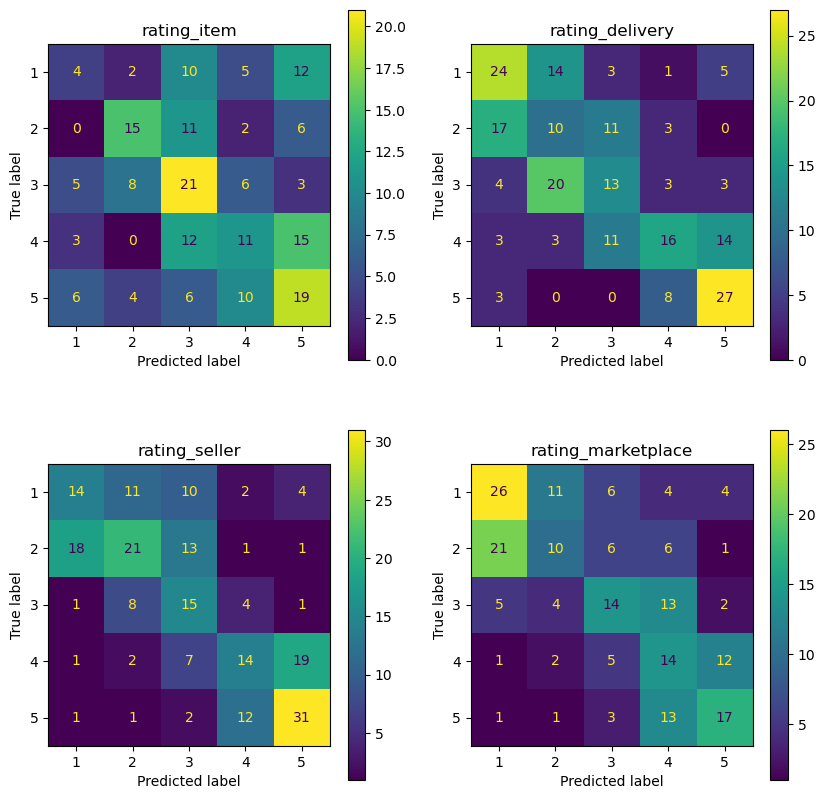

In [87]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cm = confusion_matrix(df_vr_item_pred['y_item_test'], df_vr_item_pred['y_item_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[0, 0])
axs[0, 0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_delivery_pred['y_delivery_test'], df_vr_delivery_pred['y_delivery_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_seller_pred['y_seller_test'], df_vr_seller_pred['y_seller_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_marketplace_pred['y_marketplace_test'], df_vr_marketplace_pred['y_marketplace_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[1, 1])
axs[1, 1].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [88]:
# prediction from best models

model_best = {}
model_best['item'] = max(model_accuracy['item'], key=lambda x: x['accuracy'])['model']
model_best['delivery'] = max(model_accuracy['delivery'], key=lambda x: x['accuracy'])['model']
model_best['seller'] = max(model_accuracy['seller'], key=lambda x: x['accuracy'])['model']
model_best['marketplace'] = max(model_accuracy['marketplace'], key=lambda x: x['accuracy'])['model']

y_vr_item_predict = model_best['item'].predict(X_vr_item)
y_vr_delivery_predict = model_best['delivery'].predict(X_vr_delivery)
y_vr_seller_predict = model_best['seller'].predict(X_vr_seller)
y_vr_marketplace_predict = model_best['marketplace'].predict(X_vr_marketplace)

In [90]:
df_vr_item_pred = pd.DataFrame({ 'y_item_test': df_vr['rating_item'], 'y_item_predicted': y_vr_item_predict })
df_vr_item_pred = df_vr_item_pred[df_vr_item_pred['y_item_test'] != 0]

df_vr_delivery_pred = pd.DataFrame({ 'y_delivery_test': df_vr['rating_delivery'], 'y_delivery_predicted': y_vr_delivery_predict })
df_vr_delivery_pred = df_vr_delivery_pred[df_vr_delivery_pred['y_delivery_test'] != 0]

df_vr_seller_pred = pd.DataFrame({ 'y_seller_test': df_vr['rating_seller'], 'y_seller_predicted': y_vr_seller_predict })
df_vr_seller_pred = df_vr_seller_pred[df_vr_seller_pred['y_seller_test'] != 0]

df_vr_marketplace_pred = pd.DataFrame({ 'y_marketplace_test': df_vr['rating_marketplace'], 'y_marketplace_predicted': y_vr_marketplace_predict })
df_vr_marketplace_pred = df_vr_marketplace_pred[df_vr_marketplace_pred['y_marketplace_test'] != 0]

Accuracy:  {'rating_item': 0.31155778894472363, 'rating_delivery': 0.3878504672897196, 'rating_seller': 0.4205607476635514, 'rating_marketplace': 0.44554455445544555}
Average accuracy:  0.39137838958836


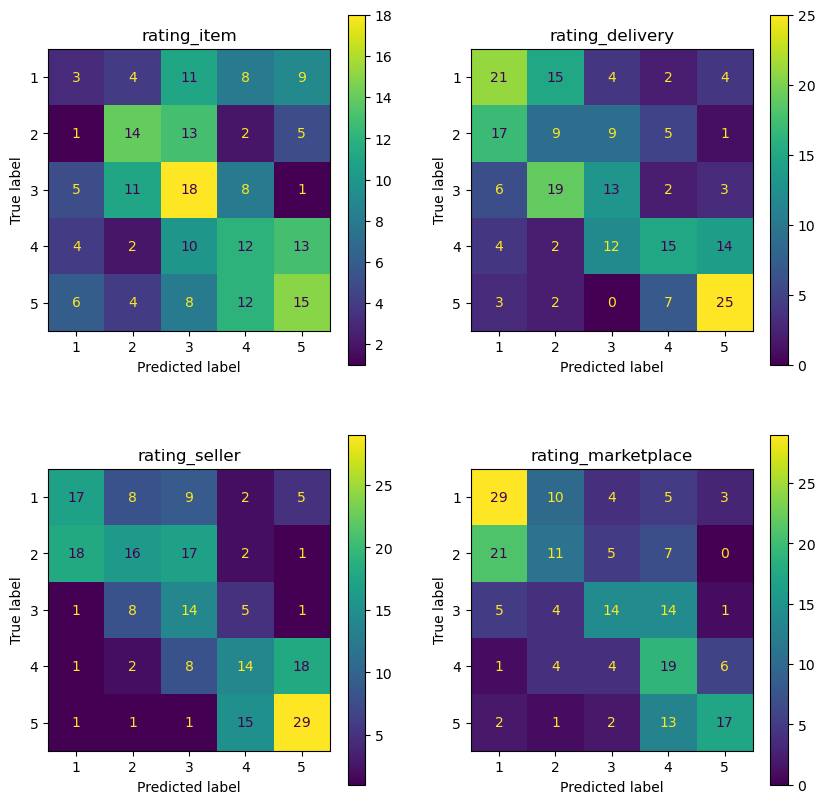

In [91]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cm = confusion_matrix(df_vr_item_pred['y_item_test'], df_vr_item_pred['y_item_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[0, 0])
axs[0, 0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_delivery_pred['y_delivery_test'], df_vr_delivery_pred['y_delivery_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_seller_pred['y_seller_test'], df_vr_seller_pred['y_seller_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr_marketplace_pred['y_marketplace_test'], df_vr_marketplace_pred['y_marketplace_predicted'], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(ax=axs[1, 1])
axs[1, 1].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [92]:
print('Model description for product')
print(classification_report(df_vr_item_pred['y_item_test'], df_vr_item_pred['y_item_predicted']))

Model description for product
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.16      0.08      0.10        39
           2       0.40      0.36      0.38        39
           3       0.30      0.42      0.35        43
           4       0.29      0.27      0.28        45
           5       0.35      0.28      0.31        53

    accuracy                           0.28       219
   macro avg       0.25      0.23      0.24       219
weighted avg       0.30      0.28      0.29       219



/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
print('Model description for delivery')
print(classification_report(df_vr_delivery_pred['y_delivery_test'], df_vr_delivery_pred['y_delivery_predicted']))

Model description for delivery
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.41      0.41      0.41        51
           2       0.19      0.20      0.20        45
           3       0.34      0.29      0.31        45
           4       0.48      0.31      0.38        49
           5       0.53      0.61      0.57        41

    accuracy                           0.36       231
   macro avg       0.33      0.30      0.31       231
weighted avg       0.39      0.36      0.37       231



/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
print('Model description for seller')
print(classification_report(df_vr_seller_pred['y_seller_test'], df_vr_seller_pred['y_seller_predicted']))

Model description for seller
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.45      0.41      0.43        41
           2       0.46      0.29      0.36        55
           3       0.29      0.47      0.35        30
           4       0.37      0.32      0.34        44
           5       0.54      0.62      0.57        47

    accuracy                           0.41       217
   macro avg       0.35      0.35      0.34       217
weighted avg       0.43      0.41      0.41       217



/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
print('Model description for the marketplace')
print(classification_report(df_vr_marketplace_pred['y_marketplace_test'], df_vr_marketplace_pred['y_marketplace_predicted']))

Model description for the marketplace
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.53      0.51        55
           2       0.37      0.22      0.27        50
           3       0.48      0.33      0.39        42
           4       0.33      0.54      0.41        35
           5       0.63      0.44      0.52        39

    accuracy                           0.41       221
   macro avg       0.38      0.34      0.35       221
weighted avg       0.46      0.41      0.42       221



/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
